### Image Ingestion

In [43]:
import os
import pandas as pd
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from collections import Counter
import torch.nn.functional as F
import gc

root_folder = 'Data_Balanced'
excel_file = 'Data_Balanced/metadata.csv'
image_folder = os.path.join(root_folder, 'images')
train_folder = os.path.join(root_folder, 'train')
test_folder = os.path.join(root_folder, 'test')

In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [45]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [46]:
# Move images to 'train' folder
for index, row in train_df.iterrows():
    image_filename = row['isic_id'] + '.jpg'
    label = row['benign_malignant']
    src_path = os.path.join(image_folder, image_filename)
    dst_path = os.path.join(train_folder, label, image_filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)


In [47]:
# Move images to 'test' folder
for index, row in test_df.iterrows():
    image_filename = row['isic_id'] + '.jpg'
    label = row['benign_malignant']
    src_path = os.path.join(image_folder, image_filename)
    dst_path = os.path.join(test_folder, label, image_filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)

In [80]:
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((512,512)),  # Resize the images to a fixed size
    transforms.RandomHorizontalFlip(), # Randomly flip images 
    transforms.RandomRotation(15), # Randomly rotate images
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image data
])

# Create datasets for 'train' and 'test' sets
train_dataset = datasets.ImageFolder(train_folder,transform = transform)
test_dataset = datasets.ImageFolder(test_folder,transform = transform)



# In each epoch, the loader will sample the entire dataset and weigh your samples inversely to your class appearing probability.
train_loader = DataLoader(train_dataset, batch_size=1,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=1,shuffle = True)



In [81]:
## Same as the other algorithm.
print(dict(Counter(train_dataset.targets)))
print(dict(Counter(test_dataset.targets)))

{0: 652, 1: 642}
{0: 648, 1: 647}


In [82]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) #bias = False?
        self.relu1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.multiplier = np.sqrt(hidden_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.output_layer(x)
        x = x*self.multiplier
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define synthetic input data
input_size = 120
synthetic_input = torch.rand(input_size)

# Instantiate the neural network
hidden_size = 20
output_size = 1
model_1 = FeedforwardNN(input_size, hidden_size, output_size)

# Forward pass
output = model_1(synthetic_input)

# To GPU
model_1 = model_1.to(device)

# Print the architecture and output shape
print(model_1)
print("Output shape:", output.shape)

FeedforwardNN(
  (layer1): Linear(in_features=120, out_features=20, bias=True)
  (relu1): ReLU()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)
Output shape: torch.Size([1])


In [83]:
initial_weights = model_1.state_dict()

In [84]:
p = 0
for name, param in model_1.named_parameters():
    if 'weight' in name:
        x,y = param.size()
        p += x*y
        print(f'Layer: {name}, Size: {param.size()}')
print('Number of parameters:',p)

Layer: layer1.weight, Size: torch.Size([20, 120])
Layer: output_layer.weight, Size: torch.Size([1, 20])
Number of parameters: 2420


In [85]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(14400, 120)
        self.fc2 = nn.Linear(120, 60)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)

In [86]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted, target):
        loss = (0.5*torch.sum((predicted - target)**2))/target.shape[0]
        return loss

In [87]:
def train_nn(input_data,best_rewards,initial_weights,step_size, J = 10):
    model_inside = FeedforwardNN(input_size, hidden_size, output_size).to(device)
    model_inside.load_state_dict(initial_weights)

    loss_function = CustomLoss()

    optimizer = optim.SGD(model_inside.parameters(),lr = step_size) # Need to fix to GD?
    size = len(input_data)
    rewards = best_rewards.reshape(-1,1)
    dataset = TensorDataset(input_data,rewards)
    
    batch_size = 50
    shuffle = True  # Set to True if you want to shuffle the data
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)    

    flattened_initial_weights = torch.cat([p.flatten() for p in initial_weights.values()])
    
    for j in range(J):
        for inputs,targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model_inside(inputs)
            loss = loss_function(output, targets)
            loss.backward() # Not sure retain_graph?
            optimizer.step()
    print('Loss',loss)
        
    print('--------------------------------------')

    model_weights = model_inside.state_dict()
    return model_weights

In [88]:
def NeuralUCB(model,image_loader,initial_weights, T,best_contexts = [],best_rewards = [],lamb = 1, step_size = 0.001):
    Z = lamb * torch.eye(p).to(device)
    K = 2
    dim = 20 # feature vector dimension (context)
    m = 20 # Neural Network width
    gamma = 1
    regrets = []
    print('best_contexts',best_contexts)
    print('best_rewards',best_rewards)
    for t, data in enumerate(image_loader,0):
        synthetic_input = [None,None]
        inputs, labels = data
        inputs = inputs.to(device)
        inputs = net(inputs)
        input_arm0 = torch.zeros(2,60).to(device)
        input_arm1 = torch.zeros(2,60).to(device)
        input_arm0[0] = inputs
        input_arm1[1] = inputs
        synthetic_input[0] = input_arm0.flatten()
        synthetic_input[1] = input_arm1.flatten()
        labels = labels.to(device)

        if labels.item() == 1: # malignant
            synthetic_label = [-2,0] # FN,TP
        else: # Benign
            synthetic_label = [0,-2] # TN,FP 
        
        all_grad = []
        ucbs = []
        for k in range(K):
            output = model(synthetic_input[k])
            model.zero_grad()
            output.backward(torch.ones_like(output),retain_graph = True)
            g = []
            for name, param in model.named_parameters():
                if 'weight' in name:
                    tmp = param.grad.flatten()
                    g.append(tmp)
            g = torch.cat(g,dim = 0).reshape(-1,1).to(device)
    
            Z_inv = torch.inverse(Z)
            
            
            all_grad.append(g)
            exploration_reward = gamma*torch.sqrt((g.T@Z_inv@g)/m) 
            ucb_a = output + exploration_reward
            ucbs.append(ucb_a.item())
            
        
        ucbs = torch.tensor(ucbs)
        best_action = torch.argmax(ucbs).item()
#         print('chosen',best_action)
        best_context = synthetic_input[best_action]
        best_g = all_grad[best_action]
        best_reward = synthetic_label[best_action]
        Z = Z + (best_g@best_g.T/m)
        best_contexts.append(best_context.detach())
        best_rewards.append(best_reward)
    
        

        if (t+1)%50 == 0:
            ### Train Neural Network
            new_weights = train_nn(torch.stack(best_contexts),
                                   torch.tensor(best_rewards),
                                   initial_weights,
                                   step_size = step_size,
                                   J = t+1)
            model.load_state_dict(new_weights)
            print(f'Training NN step {t+1}')
            print('Cumulative Regret: ' , np.sum(regrets))
        regret = np.abs(best_reward-np.max(synthetic_label))
        regrets.append(regret)
        
        if t == T:
            break
        
    
        
    return model,regrets,best_contexts,best_rewards

In [89]:
# def check_gpu_memory():
#     allocated = torch.cuda.memory_allocated()
#     reserved = torch.cuda.memory_reserved()
#     available = reserved - allocated
#     print(f"Allocated Memory: {allocated / 1024**3:.2f} GB")
#     print(f"Reserved Memory: {reserved / 1024**3:.2f} GB")
#     print(f"Available Memory: {available / 1024**3:.2f} GB")

### Image Data

In [27]:
len(train_dataset)

1294

In [90]:
model_1,regrets_1,best_contexts,best_rewards = NeuralUCB(model_1,train_loader,initial_weights,len(train_dataset))

best_contexts []
best_rewards []
Loss tensor(0.5095, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 50
Cumulative Regret:  46
Loss tensor(0.4971, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 100
Cumulative Regret:  94
Loss tensor(0.5024, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 150
Cumulative Regret:  148
Loss tensor(0.4881, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 200
Cumulative Regret:  184
Loss tensor(0.5062, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 250
Cumulative Regret:  238
Loss tensor(0.4920, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 300
Cumulative Regret:  282
Loss tensor(0.4874, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------


In [91]:
model_2,regrets_2,best_contexts,best_rewards = NeuralUCB(model_1,test_loader,initial_weights,len(test_dataset),best_contexts,best_rewards)

best_contexts [tensor([-0.1189, -0.0364,  0.0834, -0.1636,  0.0799,  0.0065, -0.0205, -0.0992,
         0.0446,  0.0762, -0.0030,  0.0796, -0.0112,  0.0723,  0.0672, -0.0506,
         0.0767, -0.1597,  0.0205, -0.2122, -0.1473, -0.0452, -0.0002,  0.1044,
        -0.0673,  0.0269,  0.0358,  0.0821,  0.0353, -0.0614, -0.1236, -0.0083,
        -0.0141, -0.0983,  0.0619,  0.0021,  0.1097, -0.0061, -0.0028,  0.1095,
         0.0369,  0.0272, -0.0807,  0.0683, -0.0450, -0.0517,  0.0305,  0.1091,
         0.1381, -0.0481, -0.0566,  0.0890,  0.1053,  0.1048,  0.0622,  0.0066,
        -0.1203,  0.1117, -0.0230, -0.0860,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,

Loss tensor(0.3537, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 50
Cumulative Regret:  22
Loss tensor(0.2730, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 100
Cumulative Regret:  58
Loss tensor(0.3096, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 150
Cumulative Regret:  98
Loss tensor(0.3354, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 200
Cumulative Regret:  132
Loss tensor(0.3404, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 250
Cumulative Regret:  162
Loss tensor(0.2790, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 300
Cumulative Regret:  196
Loss tensor(0.3038, device='cuda:0', grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 350
Cumulative Re

In [92]:
regret_total = regrets_1 + regrets_2
print(len(regret_total))

2589


In [93]:
def plot_cumulative(data):
    cumulative_sum = np.cumsum(data)
    plt.plot(cumulative_sum)
    plt.xlabel('Index')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Sum Plot')
    plt.grid(True)
    plt.show()

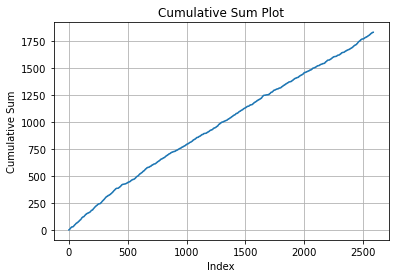

In [94]:
plot_cumulative(regret_total)

In [100]:
print('Total Regret:',np.sum(regret_total))

Total Regret: 1832


In [101]:
print('First Half Regret:',np.sum(regrets_1))

First Half Regret: 994


In [102]:
print('Second Half Regret:',np.sum(regrets_2))

Second Half Regret: 838


In [108]:
## Worse accuracy probably because it's whole dataset
correct = 0
for i, data in enumerate(test_loader, 0):
    synthetic_input = [None,None]
    inputs, labels = data
    inputs = inputs.to(device)
    inputs = net(inputs)
    input_arm0 = torch.zeros(2,60).to(device)
    input_arm1 = torch.zeros(2,60).to(device)
    input_arm0[0] = inputs
    input_arm1[1] = inputs
    synthetic_input[0] = input_arm0.flatten()
    synthetic_input[1] = input_arm1.flatten()
    labels = labels.to(device)
    
    out = np.array([model_1(synthetic_input[0]).item(),model_1(synthetic_input[1]).item()])
    out = np.argmax(out)
    label = labels.item()
    
    if out == label:
        correct += 1

In [109]:
correct/i

0.7078825347758887

In [106]:
torch.save(net.state_dict(), 'model_weights.pth')

In [107]:
np.save('regrets.npy', np.array(regret_total))